In [30]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 


In [31]:
class DataProcess:
    INVALID_ITEM = -1
    def __init__(self, data_file, data_size, config):
        self.file = data_file
        self.data_size = data_size
        self.fake_eps = config['fake_eps']
        self.min_delay = config['min_delay']
        self.max_delay = config['max_delay']
        self.max_bw = np.log(config['max_bw']*1024*1024)
        self.cong_rate = config['cong_rate']
        self.stat_size = config['stat_size']
        self.avg_weight = config['avg_weight']
        self.link_delay_map = {}
        self.path_delay_map = {}
        self.link_loads_map = {}
        self.valid_delay_map = {}
        self.valid_loads_map = {}
        self.delay_limit_map = {}
        self.quality_map = {}
        self.dataset = []
        self.target_dpids = self._get_target_dpids()
    
    def preprocess(self):
        with open(self.file, 'r+') as fp:
            for _ in range(self.data_size):
                line = fp.readline()
                if not line:
                    break 
                self._get_link_delay(line)
                self._get_data_item(line)
                self._get_link_quality(line)
    
    def _get_target_dpids(self):
        target_dpids = set()
        for ep in self.fake_eps:
            dpid = ep[0]
            target_dpids.add(dpid)
        return target_dpids
    
    def _get_link_delay(self, line):
        res_list = line.split()
        link = ''.join(res_list[:3])
        loads = float(res_list[-1])
        path_delay = float(res_list[-2])
        cs_delay = float(res_list[-3])
        sc_delay = float(res_list[-4])
        link_delay = path_delay - (cs_delay + sc_delay)/2
        if link_delay < self.min_delay:
            link_delay = self.min_delay
        link_delays = self.link_delay_map.setdefault(link, [])
        link_delays.append(link_delay)
        link_loads = self.link_loads_map.setdefault(link, [])
        link_loads.append(loads)
        path_delays = self.path_delay_map.setdefault(link, [])
        path_delays.append(path_delay)
    
    def _get_valid_delay(self, link, delay):
        valid_list = self.valid_delay_map.setdefault(link, [self.max_delay])
        if delay == DataProcess.INVALID_ITEM:
            if len(valid_list) < self.stat_size:
                item_list = self.link_delay_map[link]
                s_loc = -min(len(item_list), self.stat_size)
                valid_delay = np.median(item_list[s_loc:])
            else:
                valid_delay = np.median(valid_list)
        else:
            if len(valid_list) >= self.stat_size:
                valid_list.pop(0)
            valid_list.append(delay)
            if len(valid_list) < len(self.avg_weight):
                valid_delay = sum(valid_list)/len(valid_list)
            else:
                s_loc = -len(self.avg_weight)
                valid_delay = sum([self.avg_weight[i]*d \
                    for i, d in enumerate(valid_list[s_loc:])])
        return valid_delay
        
    def _get_valid_loads(self, link, loads):
        valid_list = self.valid_loads_map.setdefault(link, [0])
        if loads == DataProcess.INVALID_ITEM:
            valid_loads = 0
        else:
            if len(valid_list) >= self.stat_size:
                valid_list.pop(0)
            valid_list.append(loads)
            if len(valid_list) < len(self.avg_weight):
                valid_loads = sum(valid_list)/len(valid_list)
            else:
                s_loc = -len(self.avg_weight)
                valid_loads = sum([self.avg_weight[i]*d \
                    for i, d in enumerate(valid_list[s_loc:])])
        return valid_loads
        
    def _get_link_quality(self, line):
        res_list = line.split()
        link = ''.join(res_list[:3])
        delay = float(res_list[-2])
        loads = float(res_list[-1])
        
        # The key idea of this tricks locates at that, the delay beyond a so called 'max_delay' should
        # make no sense to indicate the link quality, as well as the reliability of the links.
        # Statistic of the median delay of the links of the target dpid, so as to obtain the valid delay
        # which is used to indicated the reliability of the links.
        
        if delay > self.max_delay:
            delay = self._get_valid_delay(link, 
                                         DataProcess.INVALID_ITEM)
            loads = self._get_valid_loads(link,
                                         DataProcess.INVALID_ITEM)
        else:
            delay = self._get_valid_delay(link, delay)
            loads = self._get_valid_loads(link, loads)
            
        tq = 1 - np.tanh(delay/self.max_delay)
        lq = 1 / (1 + np.exp(-(loads-self.max_bw*self.cong_rate)))
        
        # The degree of indicating link quality mainly depends on the delay quality, e.g., 
        # Link A: high loads, low delay
        # Link B: low loads, low delay
        # Link C: high loads, high delay
        # Link D: low loads, high delay 
        # we hat A > B > C > D
        # Eq. Q = (Qt + np.exp(Qt-max_Qt) * Ql) / 2, where max_Qt = 1-np.tanh(0) = 1
        quality = tq * (1 + np.exp(tq - 1) * lq) / 2 
        quality_list = self.quality_map.setdefault(link, [])
        quality_list.append(quality)
    
    def _get_data_item(self, line):
        res_list = line.split()
        src_dpid, dst_dpid = res_list[0][0], res_list[2][0]
        if not (src_dpid in self.target_dpids or dst_dpid in self.target_dpids):
            return 
        link = ''.join(res_list[:3])
        path_delay = float(res_list[-2])
        cs_delay = float(res_list[-3])
        sc_delay = float(res_list[-4])
        delay = path_delay - (cs_delay + sc_delay)/2
        if delay < self.min_delay:
            delay = self.min_delay
        if any([x in link for x in self.fake_eps]):
            is_forged_link = True 
        else:
            is_forged_link = False 
        data_item = [cs_delay, sc_delay, delay, is_forged_link]
        self.dataset.append(data_item)
    
    def query_quality_map(self):
        return self.quality_map 
    
    def query_delay_map(self):
        return self.link_delay_map
    
    def query_delay_map2(self):
        return self.path_delay_map
    
    def query_dataset(self):
        return np.array(self.dataset)

In [32]:
class MultiPathSimulator:
    def __init__(self, quality_map, gamma):
        self.quality_map = quality_map
        self.gamma = gamma

    def simulator(self, corr_links, simu_range):
        factors = {link:1 for link in corr_links}
        records = []
        for i in simu_range:
            max_quality = 0 
            for link in corr_links:
                q = self.quality_map[link][i] * factors[link]
                if q >= max_quality:
                    max_quality = q
                    best_link = link 
            records.append(corr_links.index(best_link))
            # update discount factor
            for link in corr_links:
                if link == best_link:
                    factors[link] *= self.gamma
                else:
                    factors[link] = 1
        return records
    
    def calc_period_list(self, records):
        idx = 0
        period_list = [idx]
        while idx < len(records):
            curr_rec = records[idx]
            while idx < len(records) and curr_rec == records[idx]:
                idx += 1
            if idx < len(records):
                curr_rec = records[idx]
                while idx < len(records) and curr_rec == records[idx]:
                    idx += 1
            period_list.append(idx)
        return period_list
            
    def calc_k_map(self, corr_links, records):
        k_map = {link: [] for link in corr_links}
        curr_rec = records[0]
        counter = 0
        for rec in records:
            if rec == curr_rec:
                counter += 1
            else:
                curr_link = corr_links[curr_rec]
                k_map[curr_link].append(counter)
                curr_rec = rec
                counter = 1
        return k_map            

    def calc_entropy_list(self, records, interval):
        period_list = self.calc_period_list(records)
        period_length = len(period_list)
        entropy_list = []
        num_1st = 0
        idx = 0
        for idx in range(0, period_length-interval-1):
            start = period_list[idx]
            end_idx = min(idx+interval, period_length-1)
            end = period_list[end_idx]
            seqs = np.array(records[start:end])
            num_1st = np.sum(seqs == 1)
            prob = num_1st / len(seqs)
            entropy = -prob * np.log2(prob) - (1-prob) * np.log2(1-prob)
            entropy_list.append(entropy)
        return entropy_list
    
    # discrete
    def get_k_dist(self, k_map, link):
        assert(link in k_map)
        k_values = k_map[link]
        k_set = set(k_values)
        k_prob = [k_values.count(k)/len(k_values) for k in k_set]
        return list(k_set), k_prob

In [20]:
# config dataset parameters and running parameters 

# data_size: the number of data items
# fake_eps: the endpoints of the fabricated links.
# min_delay: tx delay, set to 0.5ms in Mininet.
# max_delay: tx delay, set to 5ms empirically, a delay larger than max_delay should no longer 
#   indicate the link quality effectively.
# max_bw: maximum bandwidth, set to 100Mb/s in Mininet.
# cong_rate: congestion ratio, 80%.
# stat_size: do the statistic each 100 items.
# avg_weight: moving average of the latest 4 items.

ds_config = {
    'fake_eps': ['2:1', '4:1'],
    'min_delay': 0.5,
    'max_delay': 5,
    'max_bw': 100,
    'cong_rate': 0.8,
    'stat_size': 100,
    'avg_weight': [0.1, 0.2, 0.3, 0.4],
}

data_files = [
    r'../dataset/5switches/pcap_link_0.5_no_load_no_attack.txt',
    r'../dataset/5switches/pcap_link_0.5_no_load_attack.txt',
    r'../dataset/5switches/pcap_link_0.5_load_attack.txt',
]

data_size = 14000

normal_link_1 = '2:2->1:2'
fabricated_link_1 = '2:1->4:1'

normal_link_2 = '4:3->5:2'
fabricated_link_2 = '4:1->2:1'

processors = [DataProcess(data_file, data_size, ds_config) for data_file in data_files]

for processor in processors:
    processor.preprocess()
    
qualities = [processor.query_quality_map() for processor in processors] 

In [21]:
qualities = [processor.query_quality_map() for processor in processors]

In [22]:
quality_no_case_1 = qualities[0]
quality_no_case_2 = qualities[1]
quality_no_case_3 = qualities[2]

In [23]:

normal_link_1 = '2:2->1:2'
normal_link_2 = '2:3->3:2'
fabricated_link = '2:1->4:1'


In [24]:
gamma = 0.9
corr_links_1 = [normal_link_1, normal_link_2]
corr_links_2 = [normal_link_1, fabricated_link]
simu_1 = MultiPathSimulator(quality_no_case_1, gamma)
records_1_1 = simu_1.simulator(corr_links_1, range(0, 400))
records_1_2 = simu_1.simulator(corr_links_2, range(0, 400))
simu_2 = MultiPathSimulator(quality_no_case_2, gamma)
records_2_1 = simu_2.simulator(corr_links_1, range(0, 400))
records_2_2 = simu_2.simulator(corr_links_2, range(0, 400))
simu_3 = MultiPathSimulator(quality_no_case_3, gamma)
records_3_1 = simu_3.simulator(corr_links_1, range(0, 400))
records_3_2 = simu_3.simulator(corr_links_2, range(0, 400))


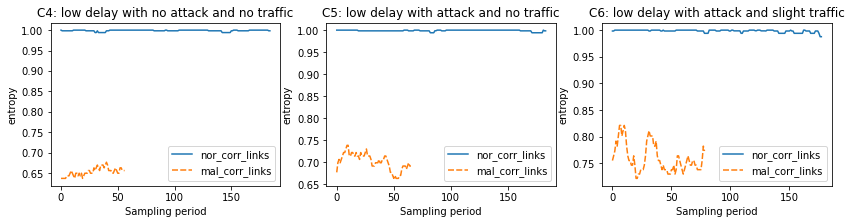

In [25]:
interval = 10
corr_links_entropy_1 = {
    'nor_corr_links': simu_1.calc_entropy_list(records_1_1, interval),
    'mal_corr_links': simu_1.calc_entropy_list(records_1_2, interval),
}

corr_links_entropy_2 = {
    'nor_corr_links': simu_2.calc_entropy_list(records_2_1, interval),
    'mal_corr_links': simu_2.calc_entropy_list(records_2_2, interval),
}

corr_links_entropy_3 = {
    'nor_corr_links': simu_3.calc_entropy_list(records_3_1, interval),
    'mal_corr_links': simu_3.calc_entropy_list(records_3_2, interval),
}

f, axes = plt.subplots(1, 3, figsize=(14, 3))
sns.lineplot(data=corr_links_entropy_1, ax=axes[0])
sns.lineplot(data=corr_links_entropy_2, ax=axes[1])
sns.lineplot(data=corr_links_entropy_3, ax=axes[2])
axes[0].set_xlabel('Sampling period')
axes[0].set_ylabel('entropy')
axes[1].set_xlabel('Sampling period')
axes[1].set_ylabel('entropy')
axes[2].set_xlabel('Sampling period')
axes[2].set_ylabel('entropy')
axes[0].set_title('C4: low delay with no attack and no traffic')
axes[1].set_title('C5: low delay with attack and no traffic')
axes[2].set_title('C6: low delay with attack and slight traffic')
f.savefig('entropy_snap.png', format='png', bbox_inches='tight', dpi=300, transparent=True)

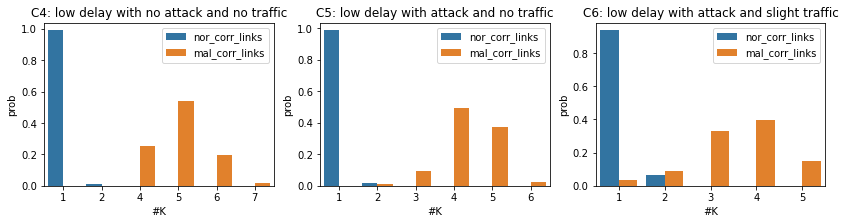

In [29]:
k_map_1_1 = simu_1.calc_k_map(corr_links_1, records_1_1)
k_map_1_2 = simu_1.calc_k_map(corr_links_2, records_1_2)

k_map_2_1 = simu_2.calc_k_map(corr_links_1, records_2_1)
k_map_2_2 = simu_2.calc_k_map(corr_links_2, records_2_2)

k_map_3_1 = simu_3.calc_k_map(corr_links_1, records_3_1)
k_map_3_2 = simu_3.calc_k_map(corr_links_2, records_3_2)

k_values_1_1, prob_list_1_1 = simu_1.get_k_dist(k_map_1_1, normal_link_1)
k_values_1_2, prob_list_1_2 = simu_1.get_k_dist(k_map_1_2, normal_link_1)

k_values_2_1, prob_list_2_1 = simu_2.get_k_dist(k_map_2_1, normal_link_1)
k_values_2_2, prob_list_2_2 = simu_2.get_k_dist(k_map_2_2, normal_link_1)

k_values_3_1, prob_list_3_1 = simu_3.get_k_dist(k_map_3_1, normal_link_1)
k_values_3_2, prob_list_3_2 = simu_3.get_k_dist(k_map_3_2, normal_link_1)

def combined_list(klist_1, klist_2, plist_1, plist_2):
    klist_new = []
    plist_new = []
    kset = set(klist_1) | set(klist_2)
    for k in kset:
        klist_new.append(k)
        if k not in klist_1:
            plist_new.append(0)
        else:
            plist_new.append(plist_1[klist_1.index(k)])
        klist_new.append(k)
        if k not in klist_2:
            plist_new.append(0)
        else:
            plist_new.append(plist_2[klist_2.index(k)])
    return klist_new, plist_new
        
k_list_1, p_list_1 = combined_list(
    k_values_1_1, k_values_1_2, 
    prob_list_1_1, prob_list_1_2)

k_list_2, p_list_2 = combined_list(
    k_values_2_1, k_values_2_2, 
    prob_list_2_1, prob_list_2_2)

k_list_3, p_list_3 = combined_list(
    k_values_3_1, k_values_3_2, 
    prob_list_3_1, prob_list_3_2)

corr_links_k_1 = {
    'corr_links': ['nor_corr_links', 'mal_corr_links'] * (len(k_list_1)//2),
    'p_list': p_list_1,
    'k_list': k_list_1,
}

corr_links_k_2 = {
    'corr_links': ['nor_corr_links', 'mal_corr_links']* (len(k_list_2)//2),
    'p_list': p_list_2,
    'k_list': k_list_2,
}

corr_links_k_3 = {
    'corr_links': ['nor_corr_links', 'mal_corr_links']* (len(k_list_3)//2),
    'p_list': p_list_3,
    'k_list': k_list_3,
}

f, axes = plt.subplots(1, 3, figsize=(14, 3))

sns.barplot(data=corr_links_k_1, ax=axes[0], x='k_list', y='p_list', hue='corr_links')
sns.barplot(data=corr_links_k_2, ax=axes[1], x='k_list', y='p_list', hue='corr_links')
sns.barplot(data=corr_links_k_3, ax=axes[2], x='k_list', y='p_list', hue='corr_links')
axes[0].set_xlabel('#K')
axes[0].set_ylabel('prob')
axes[1].set_xlabel('#K')
axes[1].set_ylabel('prob')
axes[2].set_xlabel('#K')
axes[2].set_ylabel('prob')
axes[0].set_title('C4: low delay with no attack and no traffic')
axes[1].set_title('C5: low delay with attack and no traffic')
axes[2].set_title('C6: low delay with attack and slight traffic')
f.savefig('k_snap.png', format='png', bbox_inches='tight', dpi=300, transparent=True)

In [27]:
# config dataset parameters and running parameters 

# data_size: the number of data items
# fake_eps: the endpoints of the fabricated links.
# min_delay: tx delay, set to 0.5ms in Mininet.
# max_delay: tx delay, set to 5ms empirically, a delay larger than max_delay should no longer 
#   indicate the link quality effectively.
# max_bw: maximum bandwidth, set to 100Mb/s in Mininet.
# cong_rate: congestion ratio, 80%.
# stat_size: do the statistic each 100 items.
# avg_weight: moving average of the latest 4 items.

ds_config = {
    'fake_eps': ['2:1', '4:1'],
    'min_delay': 0.5,
    'max_delay': 5,
    'max_bw': 100,
    'cong_rate': 0.8,
    'stat_size': 100,
    'avg_weight': [0.1, 0.2, 0.3, 0.4],
}

data_size = 1000000

normal_link = '2:2->1:2'
fabricated_link = '2:1->4:1'


mal_corr_links = [normal_link, fabricated_link]

gamma = 0.9
scales = [i for i in range(10, 110, 10)]

for scale in scales:
    data_file = '../dataset/{}switches/pcap_link_0.5_load_attack.txt'.format(scale)
    processor = DataProcess(data_file, data_size, ds_config)
    processor.preprocess()
    quality_map = processor.query_quality_map()
    simu = MultiPathSimulator(quality_map, gamma)
    records = simu.simulator(mal_corr_links, range(0, 3000))
    k_map = simu.calc_k_map(mal_corr_links, records)
    k_list, k_prob = simu.get_k_dist(k_map, normal_link)
    k_exp = sum([k_list[i]*p for i, p in enumerate(k_prob)])
    with open('k_exp.txt', 'a+') as fp:
        fp.write('{}:{}\n'.format(scale, np.round(k_exp, 4)))

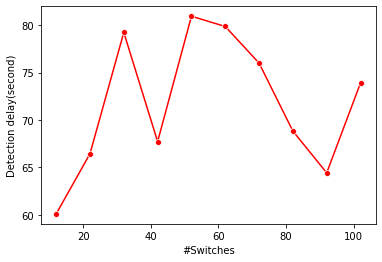

In [33]:
delay_list = []
interval = 10
period = 2
scales = [i for i in range(10, 110, 10)]
index = [scale+2 for scale in scales]
with open('k_exp.txt', 'r') as fp:
    for scale in scales:
        line = fp.readline()
        if not line:
            break 
        k_exp = float(line.split(':')[-1])
        delay_list.append(k_exp*interval*period)

data = {
    'Detection delay(second)': delay_list,
    '#Switches': index
}

sns.lineplot(data=data, x='#Switches', y='Detection delay(second)', color='red', marker='o')
plt.savefig('detection_delay.png', format='png', bbox_inches='tight', dpi=300, transparent=True)